In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/COSC_757_Project/NYPD_Calls_Cleaned_Data.csv')

In [ ]:
data.head()

,CAD_EVNT_ID,CREATE_DATE,INCIDENT_DATE,INCIDENT_TIME,NYPD_PCT_CD,BORO_NM,TYP_DESC,CIP_JOBS,ADD_TS,DISP_TS,ARRIVD_TS,CLOSNG_TS,Latitude,Longitude,Cluster,Cluster_Label,RESPONSE_TS,INCIDENT_HOUR
0,91250176,2023-01-01,2022-12-31,23:24:39,67.0,2,vehicle accident injury,1,2023-01-01 01:08:21,2023-01-01 01:09:57,2023-01-01 01:09:57,2023-01-01 01:57:44,40.649730,-73.936475,8,Directed Patrols and Inspections,0.000098,23
1,91250180,2023-01-01,2022-12-31,23:24:47,75.0,2,alarms commercialburglary,1,2023-01-01 00:38:00,2023-01-01 00:38:34,2023-01-01 00:44:33,2023-01-01 01:45:21,40.662817,-73.881221,6,Burglary Alarms,0.000402,23
2,91250681,2023-01-01,2022-12-31,23:55:56,114.0,4,alarms residentialburglary,1,2023-01-01 00:01:26,2023-01-01 00:06:18,2023-01-01 00:06:18,2023-01-01 00:06:27,40.762587,-73.912199,6,Burglary Alarms,0.000299,23
3,91250683,2023-01-01,2022-12-31,23:55:59,66.0,2,alarms residentialburglary,1,2023-01-01 00:01:34,2023-01-01 00:37:14,2023-01-01 01:09:32,2023-01-01 01:21:14,40.610729,-73.967644,6,Burglary Alarms,0.004174,23
4,91250700,2023-01-01,2022-12-31,23:57:08,115.0,4,alarms commercialburglary,1,2023-01-01 00:01:29,2023-01-01 00:14:28,2023-01-01 00:21:59,2023-01-01 01:24:22,40.748119,-73.891679,6,Burglary Alarms,0.001259,23


### **SARIMAX - Time Series Model**

In [ ]:
# Convert INCIDENT_DATE and INCIDENT_TIME to a single datetime column
data['DATETIME'] = pd.to_datetime(data['INCIDENT_DATE'] + ' ' + data['INCIDENT_TIME'])

# Set the DATETIME as the index
data.set_index('DATETIME', inplace=True)

# Resample the data to hourly frequency and count the number of incidents per hour
hourly_counts = data.resample('H').size()

# Display the first few entries to check the transformation
hourly_counts


DATETIME
2022-12-31 23:00:00       6
2023-01-01 00:00:00     910
2023-01-01 01:00:00    1043
2023-01-01 02:00:00     790
2023-01-01 03:00:00     684
                       ... 
2023-12-31 19:00:00     855
2023-12-31 20:00:00     801
2023-12-31 21:00:00     890
2023-12-31 22:00:00     876
2023-12-31 23:00:00     743
Freq: H, Length: 8761, dtype: int64

In [ ]:
# Perform Augmented Dickey-Fuller test
# This tests the null hypothesis that the time series is non-stationary.
adf_test = adfuller(hourly_counts)

# Display the ADF test results
# adf_test[0]: ADF test statistic
# adf_test[1]: p-value of the test statistic
# adf_test[2]: Number of lags used in the regression
# adf_test[3]: Number of observations used for the ADF regression
# adf_test[4]: Critical values (dict) for test at 1%, 5%, and 10% significance levels
adf_results = {
    'ADF Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Critical Values': adf_test[4],
    'Used Lags': adf_test[2],
    'Number of Observations': adf_test[3]
}

adf_results


{'ADF Statistic': -7.444180729401889,
 'p-value': 5.897601646918341e-11,
 'Critical Values': {'1%': -3.431099882538333,
  '5%': -2.8618713981324873,
  '10%': -2.56694639826003},
 'Used Lags': 37,
 'Number of Observations': 8723}

`model = SARIMAX(hourly_counts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))`
Here, we're defining a SARIMA (Seasonal AutoRegressive Integrated Moving Average) model using the SARIMAX class from the statsmodels library.

**hourly_counts:**
This is the time series data containing the hourly incident counts. It's the dependent variable that we want to forecast.

**Order Parameter (order=(p, d, q)):**
The order parameter specifies the non-seasonal components of the SARIMA model.
It consists of three integers: (p, d, q), corresponding to the autoregressive (AR), differencing (I), and moving average (MA) terms, respectively.
- AR (p): Represents the number of lagged observations included in the model. It captures the linear relationship between the current value and its lagged values. Higher values of p indicate a longer memory of the past values in the model.
- Differencing (d): Represents the degree of differencing applied to the time series data. Differencing removes trends and seasonality from the data, making it stationary. A value of 1 for d indicates first-order differencing, while higher values denote higher orders of differencing.
- MA (q): Represents the number of lagged forecast errors included in the model. It captures the dependency between the current value and its past forecast errors. Higher values of q indicate a longer memory of the past forecast errors in the model.

**Seasonal_Order Parameter (seasonal_order=(P, D, Q, m)):**
The seasonal_order parameter specifies the seasonal components of the SARIMA model.
It consists of four integers: (P, D, Q, m), corresponding to the seasonal autoregressive (SAR), seasonal differencing (SI), seasonal moving average (SMA), and seasonal period, respectively.
- Seasonal AR (P): Represents the seasonal order of the autoregressive component. It captures the seasonal relationship between observations at the specified seasonal lag.
- Seasonal Differencing (D): Represents the degree of seasonal differencing applied to the time series data. Similar to non-seasonal differencing, seasonal differencing removes seasonal patterns from the data to make it stationary.
- Seasonal MA (Q): Represents the seasonal order of the moving average component. It captures the seasonal dependency between observations at the specified seasonal lag.
- Seasonal Period (m): Represents the number of time steps in each seasonal cycle. For example, if the data is hourly and exhibits daily seasonality, m would be set to 24. It determines the frequency of the seasonal pattern.

In [ ]:
# Define the SARIMA model with tentative parameters
model = SARIMAX(hourly_counts, order=(1, 1, 1), seasonal_order=(1,1, 1, 24))

# Fit the model to the data
# disp=False: prevents the printing of fitting output
sarima_results = model.fit(disp=False)

# Display the summary of the model
sarima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 8761
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -47229.780
Date:                            Thu, 09 May 2024   AIC                          94469.560
Time:                                    15:54:06   BIC                          94504.936
Sample:                                12-31-2022   HQIC                         94481.616
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8069      0.004    200.564      0.000       0.799       0.815
ma.L1         -0.9999      0.001   -905.383      0.000      -1.002      -0.998
ar.S.L24       0.2039      0.009     22.734      0.000       0.186       0.221
ma.S.L24      -0.9399      0.004   -248.881      0.000      -0.947      -0.933
sigma2      2896.4723     18.452    156.970      0.000    2860.306    2932.638
===================================================================================
Ljung-Box (L1) (Q):                  54.78   Jarque-Bera (JB):             45323.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                        14.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

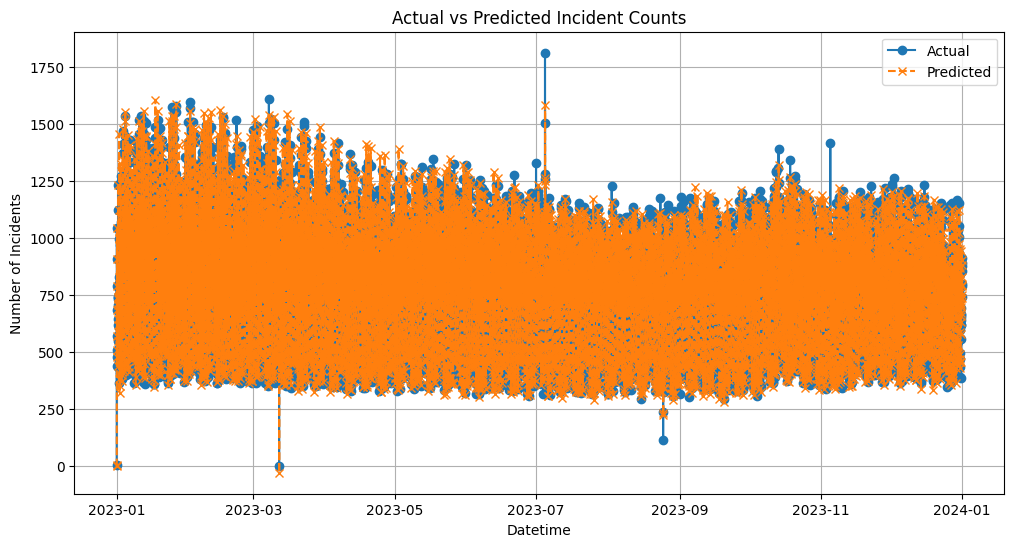

,Actual,Predicted
DATETIME,,
2022-12-31 23:00:00,6,0.000000
2023-01-01 00:00:00,910,5.998558
2023-01-01 01:00:00,1043,909.565436
2023-01-01 02:00:00,790,1042.586047
2023-01-01 03:00:00,684,789.788089
...,...,...
2023-12-31 19:00:00,855,749.226197
2023-12-31 20:00:00,801,792.715571
2023-12-31 21:00:00,890,789.409277


In [ ]:
# Generate in-sample predictions
predictions = sarima_results.get_prediction(start=hourly_counts.index[0], end=hourly_counts.index[-1])
predictions_mean = predictions.predicted_mean

# Compare with actual data
comparison_df = pd.DataFrame({
    'Actual': hourly_counts,
    'Predicted': predictions_mean
})

# Plotting the observed vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'], label='Predicted', linestyle='--', marker='x')
plt.title('Actual vs Predicted Incident Counts')
plt.xlabel('Datetime')
plt.ylabel('Number of Incidents')
plt.legend()
plt.grid(True)
plt.show()

comparison_df


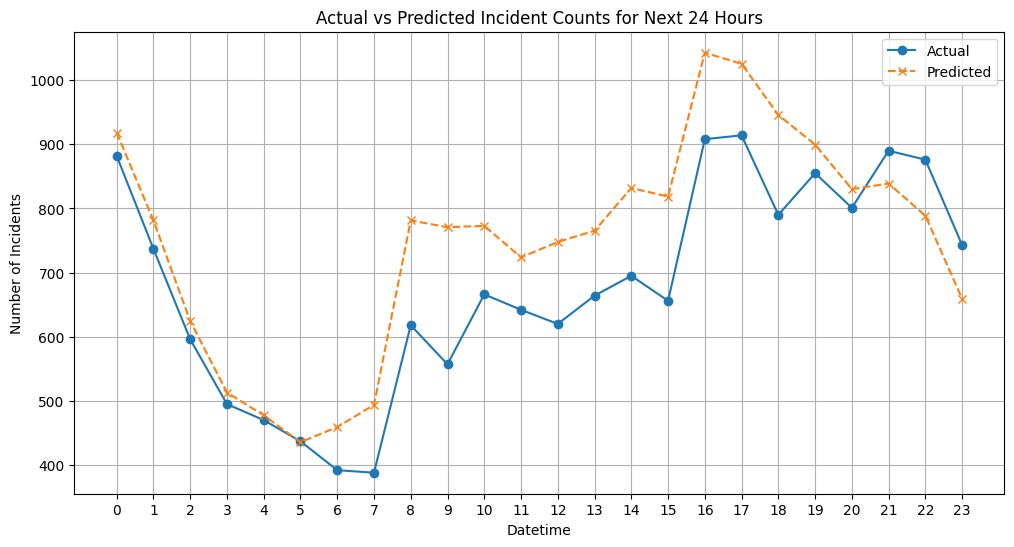

In [ ]:
# Generate in-sample predictions for the next 24 hours
forecast_horizon = 24 # Set the forecast horizon to 24 hours ahead

# Determine the index for the last point of the prediction window by adding 24 hours to the last index
end_index = hourly_counts.index[-1] + pd.Timedelta(hours=forecast_horizon)

# Generate predictions from the model using `get_prediction` method
predictions = sarima_results.get_prediction(start=hourly_counts.index[0], end=end_index)
predictions_mean = predictions.predicted_mean[-forecast_horizon:] # Extract the last 24 hours of predictions from the prediction results

# Subset actual data for the next 24 hours
actual_next_24_hours = hourly_counts[-forecast_horizon:]

# Plotting the observed vs predicted values for the next 24 hours
plt.figure(figsize=(12, 6))
plt.plot(actual_next_24_hours.index, actual_next_24_hours.values, label='Actual', marker='o')
plt.plot(actual_next_24_hours.index, predictions_mean, label='Predicted', linestyle='--', marker='x')
plt.title('Actual vs Predicted Incident Counts for Next 24 Hours')
plt.xlabel('Datetime')
plt.ylabel('Number of Incidents')
plt.xticks(actual_next_24_hours.index, actual_next_24_hours.index.hour)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Evaluate the model's performance

# Calculate evaluation metrics
mae = mean_absolute_error(actual_next_24_hours, predictions_mean)
mse = mean_squared_error(actual_next_24_hours, predictions_mean)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_next_24_hours - predictions_mean) / np.maximum(np.abs(actual_next_24_hours), 1))) * 100

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 87.54083442532988
Mean Squared Error (MSE): 10719.136866895742
Root Mean Squared Error (RMSE): 103.5332645428306


**Including Spatial features**

To check if it improves the model. The features considered are:
- NYPD_PCT_CD
- BORO_NM
- Lattitude
- Longitude

In [ ]:
# Check for duplicate index labels in hourly_counts
spatial_features = data[['NYPD_PCT_CD', 'BORO_NM', 'Latitude', 'Longitude']]

duplicate_index = hourly_counts.index.duplicated(keep=False)
if duplicate_index.any():
    print("Duplicate index labels found. Resolving...")

    # Handle duplicate labels (e.g., remove duplicates or aggregate data)
    hourly_counts = hourly_counts[~duplicate_index].groupby(level=0).sum()  # Example: Aggregate by sum

    print("Duplicate index labels resolved.")

# Debugging: Print indices of hourly_counts and spatial_features
# print("hourly_counts index:", hourly_counts.index)
# print("spatial_features index:", spatial_features.index)

# Extract spatial features and align indices
spatial_features = data[['NYPD_PCT_CD', 'BORO_NM', 'Latitude', 'Longitude']]
hourly_spatial_features = spatial_features.resample('H').sum()  # Example: Summing over hourly intervals

# Define the SARIMA model with exogenous variables
model = SARIMAX(hourly_counts, exog=hourly_spatial_features,
                order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))

# Fit the model
sarima_results = model.fit(disp=False)

# Display the summary of the model
print(sarima_results.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 8761
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood               19902.233
Date:                            Thu, 09 May 2024   AIC                         -39786.466
Time:                                    15:56:22   BIC                         -39722.789
Sample:                                12-31-2022   HQIC                        -39764.766
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
NYPD_PCT_CD  1.414e-05   3.08e-07     45.976      0.000    1.35e-05    1.47e-05
BORO_NM     -3.789e-05   9.75e-0

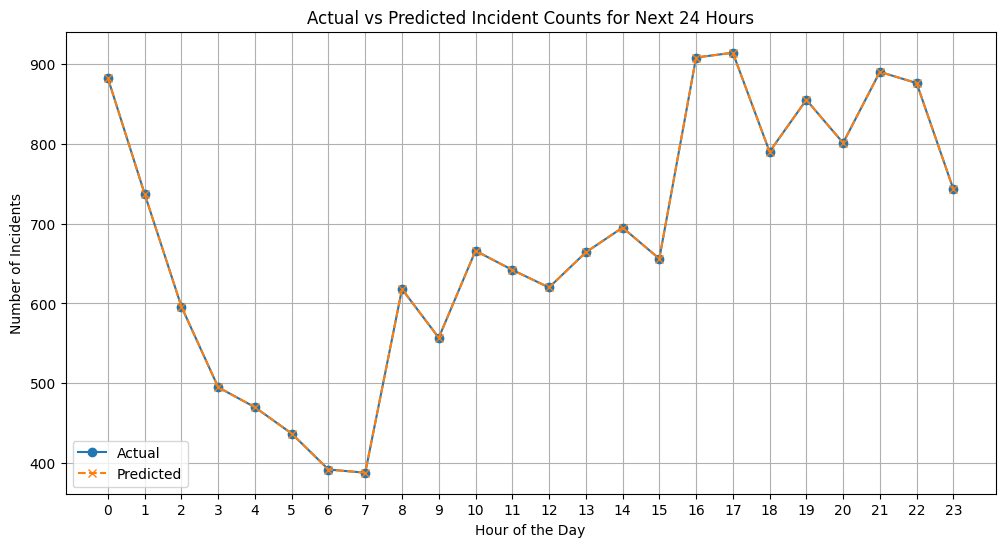

In [ ]:
# Generate exogenous variable values for the forecast period
forecast_horizon = 24  # Number of forecast periods (hours in this case)
forecast_exog = hourly_spatial_features[-forecast_horizon:]  # Use the last available exogenous values for forecasting

# Generate in-sample predictions for the next 24 hours
end_index = hourly_counts.index[-1] + pd.Timedelta(hours=forecast_horizon)
predictions = sarima_results.get_prediction(start=hourly_counts.index[0], end=end_index, exog=forecast_exog)
predictions_mean = predictions.predicted_mean[-forecast_horizon:]

# Subset actual data for the next 24 hours
actual_next_24_hours = hourly_counts[-forecast_horizon:]

# Plotting the observed vs predicted values for the next 24 hours
plt.figure(figsize=(12, 6))
plt.plot(actual_next_24_hours.index, actual_next_24_hours.values, label='Actual', marker='o')
plt.plot(actual_next_24_hours.index, predictions_mean, label='Predicted', linestyle='--', marker='x')
plt.title('Actual vs Predicted Incident Counts for Next 24 Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Incidents')
plt.xticks(actual_next_24_hours.index, actual_next_24_hours.index.hour)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_next_24_hours, predictions_mean)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_next_24_hours, predictions_mean)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 0.010736639841364118
Mean Squared Error (MSE): 0.00016475470829072528
Root Mean Squared Error (RMSE): 0.012835681060649851


In [ ]:
# Assuming you have a continuous time index
split_point = int(len(hourly_counts) * 0.8)  # 80% for training
train_counts, test_counts = hourly_counts.iloc[:split_point], hourly_counts.iloc[split_point:]
train_features, test_features = hourly_spatial_features.iloc[:split_point], hourly_spatial_features.iloc[split_point:]

# Fit the model on training data
train_model = SARIMAX(train_counts, exog=train_features,
                      order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
train_results = train_model.fit(disp=False)

# Make predictions on the test data
predictions = train_results.get_forecast(steps=len(test_counts), exog=test_features)
predicted_counts = predictions.predicted_mean

# Evaluate the predictions (using Mean Absolute Error for simplicity)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_counts, predicted_counts)
print(f"Mean Absolute Error on Test Data: {mae}")

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error on Test Data: 0.1718752449615607


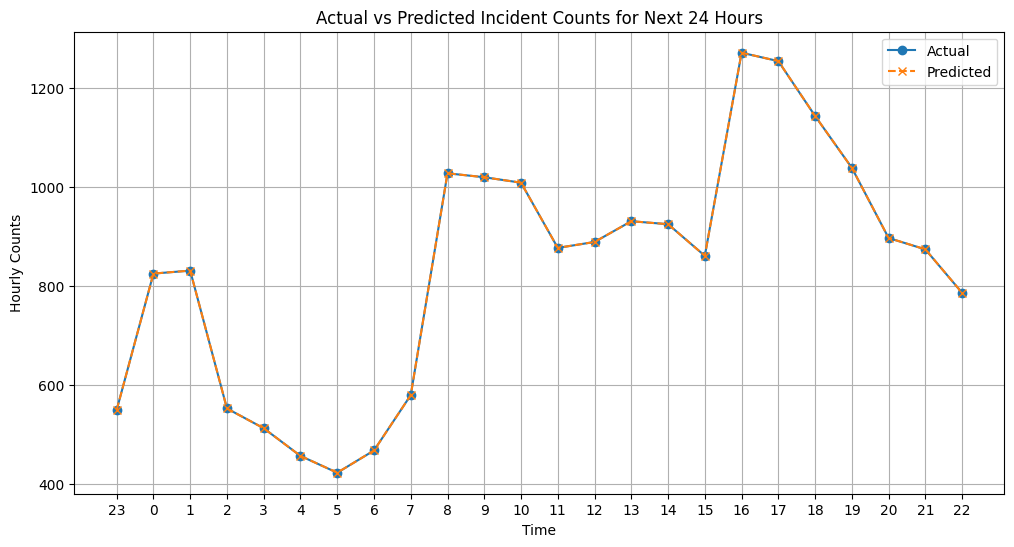

In [ ]:
import matplotlib.pyplot as plt

# Assuming actual_next_24_hours.index represents the time index for your test data
# Plot actual values
plt.figure(figsize=(12, 6))
plt.plot(test_counts.index[:24], test_counts.values[:24], label='Actual', marker='o')

# Plot predicted values
plt.plot(test_counts.index[:24], predicted_counts.values[:24], label='Predicted', linestyle='--', marker='x')

plt.title('Actual vs Predicted Incident Counts for Next 24 Hours')
plt.xlabel('Time')
plt.ylabel('Hourly Counts')
plt.xticks(test_counts.index[:24], test_counts.index[:24].hour)
plt.legend()
plt.grid(True)
plt.show()
